In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

# Tải dữ liệu Fashion MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_nums = len(class_names)

In [ ]:
# ONE HOT ENCODER
y_train_label = to_categorical(y_train, num_classes=class_nums)
y_test_label = to_categorical(y_test, num_classes=class_nums)


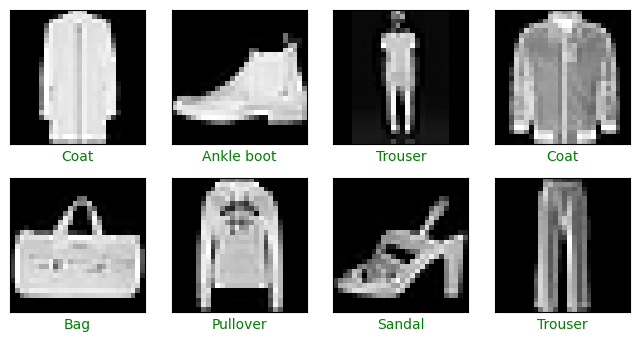

In [ ]:
def showImage(X_data: np.ndarray, y_data: np.ndarray) -> None:
    nrows, ncols = 2,4
    fig, axes  = plt.subplots(nrows, ncols, figsize = (8,4))
    # figsize ngang 8 cao 4 của 1 figure
    len_x = X_data.shape[0]
    for idx in range(nrows*ncols):
        ax = axes[idx//ncols, idx%ncols]
        img_idx = random.randint(0, len_x)
        ax.imshow(X_data[img_idx], cmap='gray')
        ax.set(xticks=[], yticks = [])
        true_label_str = f'{class_names[y_data[img_idx]]}'
        ax.set_xlabel(true_label_str, color = 'green')

showImage(X_train, y_train)

In [ ]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

In [ ]:
class NN:
    def __init__(self, sizes = [784, 512,256, 10], learning_rate = 0.001, epochs = 200, lambda_l2=0.01):
        self.sizes = sizes
        self.input_size = sizes[0]
        self.hidden1_size = sizes[1]
        self.hidden2_size = sizes[2]
        self.output_size = sizes[3]

        self.lambda_l2 = lambda_l2

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_history = []

        self.params = {
            'W1': np.random.randn(self.input_size, self.hidden1_size) * np.sqrt(2.0/self.input_size),
            'W2': np.random.randn(self.hidden1_size, self.hidden2_size) * np.sqrt(2.0/self.hidden1_size),
            'W3': np.random.randn(self.hidden2_size, self.output_size) * np.sqrt(2.0/self.hidden2_size),
            'b1': np.zeros((1, self.hidden1_size)),
            'b2': np.zeros((1, self.hidden2_size)),
            'b3': np.zeros((1, self.output_size)),

        }

    def activation(self, z):
        return np.maximum(0, z)


    def activation_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def forward_props(self, input_list):
        params = self.params

        params['Z1'] = np.dot(input_list, params['W1']) + params['b1']
        params['A1'] = self.activation(params['Z1'])
        params['Z2'] = np.dot(params['A1'], params['W2']) + params['b2']
        params['A2'] = self.activation(params['Z2'])
        params['Z3'] = np.dot(params['A2'], params['W3']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']
    def crossentropy_loss_function(self, predict_value, actual_value):
        epsilon = 1e-9
        predict_value = np.clip(predict_value, epsilon, 1 - epsilon)
        loss = -np.sum(actual_value * np.log(predict_value)) / len(actual_value)

        l2_regularization = 0.5 * self.lambda_l2 * (np.sum(self.params['W1']**2) + np.sum(self.params['W2']**2) + np.sum(self.params['W3']**2))

        loss += l2_regularization

        return loss

    def backward_props(self, inputs_list, targets_list):
        params = self.params
        m = len(inputs_list)

        # Number 3 layer
        dA3 = params['A3'] - targets_list
        dZ3 = dA3 * self.activation_derivative(params['Z3'])

        dW3 = np.dot(params['A2'].T, dZ3) / m + self.lambda_l2 * params['W3']
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m


        # Number 2 layer
        dA2 = np.dot(dZ3, params['W3'].T)
        dZ2 = dA2 * self.activation_derivative(params['Z2'])

        dW2 = np.dot(params['A1'].T, dZ2) / m + self.lambda_l2 * params['W2']
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m


        # Number 1 Layer
        dA1 = np.dot(dZ2, params['W2'].T)
        dZ1 = dA1 * self.activation_derivative(params['Z1'])

        dW1 = np.dot(inputs_list.T, dZ1) / m + self.lambda_l2 * params['W1']
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        params['W3'] -= self.learning_rate * dW3
        params['b3'] -= self.learning_rate * db3
        params['W2'] -= self.learning_rate * dW2
        params['b2'] -= self.learning_rate * db2
        params['W1'] -= self.learning_rate * dW1
        params['b1'] -= self.learning_rate * db1

    def train(self, inputs_list, targets_list, batch_size=128):
        m = len(inputs_list)

        for epoch in range(self.epochs):

            permutation = np.random.permutation(m)
            inputs_list_shuffled = inputs_list[permutation]
            targets_list_shuffled = targets_list[permutation]

            for i in range(0, m, batch_size):
                batch_indices = np.arange(i, min(i + batch_size, m))
                batch_inputs = inputs_list_shuffled[batch_indices]
                batch_targets = targets_list_shuffled[batch_indices]
                self.forward_props(batch_inputs)
                loss = self.crossentropy_loss_function(self.params['A3'], batch_targets)
                self.backward_props(batch_inputs, batch_targets)
            print(f'Epoch {epoch + 1}/{self.epochs}, Loss: {loss}')
            self.loss_history.append(loss)
        self.plot_loss_history()

    def predict(self, X):
        output = self.forward_props(X)
        return output

    def plot_loss_history(self):
        plt.plot(range(1, self.epochs + 1), self.loss_history, marker='o')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()


Epoch 1/200, Loss: 9.440376816692378
Epoch 2/200, Loss: 9.154908633814197
Epoch 3/200, Loss: 8.974380757482471
Epoch 4/200, Loss: 8.77751763248912
Epoch 5/200, Loss: 8.720276504996617
Epoch 6/200, Loss: 8.793639023616825
Epoch 7/200, Loss: 8.396127415315574
Epoch 8/200, Loss: 8.24047366368453
Epoch 9/200, Loss: 8.12963486752802
Epoch 10/200, Loss: 8.255092773803678
Epoch 11/200, Loss: 8.14324487699264
Epoch 12/200, Loss: 8.063397144784652
Epoch 13/200, Loss: 8.270507065053428
Epoch 14/200, Loss: 7.753828228420435
Epoch 15/200, Loss: 7.816471389231341
Epoch 16/200, Loss: 7.771442623898463
Epoch 17/200, Loss: 7.570809257910803
Epoch 18/200, Loss: 7.786473332066995
Epoch 19/200, Loss: 7.282245958398279
Epoch 20/200, Loss: 7.402222071375867
Epoch 21/200, Loss: 7.500702571526487
Epoch 22/200, Loss: 7.394814681773245
Epoch 23/200, Loss: 7.390185003377061
Epoch 24/200, Loss: 7.02633152172828
Epoch 25/200, Loss: 7.362828407755868
Epoch 26/200, Loss: 7.173544317001123
Epoch 27/200, Loss: 7.0598

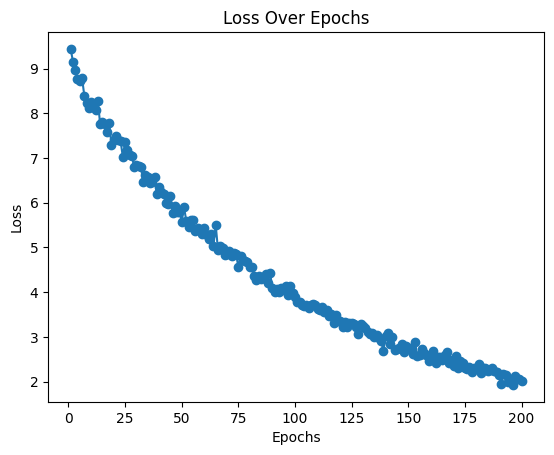

In [ ]:
nn = NN()
nn.train(X_train_flatten, y_train_label)

In [ ]:
predictions = nn.predict(X_test_flatten)

In [ ]:
from typing import Optional

def showImageTested(X_data: np.ndarray, y_data: np.ndarray, y_prob: Optional[np.ndarray] = None) -> None:
  nrows, ncols = 2,4
  fig, axes  = plt.subplots(nrows, ncols, figsize = (8,4))
  # figsize ngang 8 cao 4 của 1 figure

  len_x = X_data.shape[0]

  for idx in range(nrows*ncols):
    ax = axes[idx//ncols, idx%ncols]
    img_idx = random.randint(0, len_x)

    ax.imshow(X_data[img_idx], cmap='gray')
    ax.set(xticks=[], yticks = [])

    true_label_str = f'{class_names[y_data[img_idx]]}'

    color = 'green'

    if y_prob is not None:
      predicted_idx = np.argmax(y_prob[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f'\nPredicted: {predicted_label}'


    img_title = true_label_str if y_prob is None else true_label_str + predicted_label_str
    ax.set_xlabel(img_title, color = color)

  plt.tight_layout()
  plt.show()



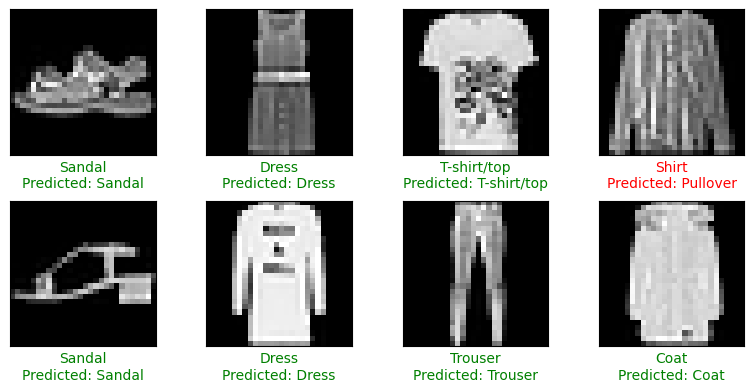

In [ ]:
showImageTested(X_test, y_test, predictions)
